# Notebook Overview: Classifying Human Needs from Text

This notebook focuses on the challenging task of need classification. Unlike sentiment analysis, which typically categorizes text as positive or negative, need classification involves a more nuanced understanding of human psychology, as needs are often implicit, context-dependent, and semantically nuanced in nature.

For this project, we leverage the theory and the dataset provided by Alharthi et al, 2017, "A Dataset for Psychological Human Needs Detection from Social Networks". The dataset serves as the foundation for our classification task.

To address the complexities of need classification, we employ a two-stage approach:

* Prompt Engineering with Google’s LLMs: Using Google’s language models for few-shot and zero-shot learning to experiment with need classification.

* Neural Network Training with Embeddings: Utilizing Google’s text-embedding-004 API to generate embeddings, which are then used to train a neural network to improve need classification.

In [ ]:
# importing libraries
from google import genai
from google.genai import types
from IPython.display import HTML, Markdown, display

In [ ]:
#creating a client object thas acts as interface to google
client = genai.Client(api_key="YOUR_API_KEY")


# 0 shot prompting

This code configures the LLM google model(i.e. gemini-2.0-flash), asks it to classify a tweet based on human needs, and then prints the AI's classification.

The "zero-shot"  implies that the AI is attempting this task without any prior examples, relying solely on the instructions given.

In [ ]:
#Setting up the Model Configuration and Prompt
model_config = types.GenerateContentConfig(
    temperature=2, #this parameter controls the randomness of the response
    top_p=1,# selects words from the smallest set whose probabilities sum to at least p
    max_output_tokens=200, # limits the length of the AI's response
)

zero_shot_prompt = """Classify twitters as expressing basic human needs of the kind AUTONOMY, COMPETENCE or RELATEDNESS.
Twitter:Laptop crashed. Couldn't have happened at a worse time. #Frustrated #firstworldproblems
Need: """

# Generating and Printing the Response
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=zero_shot_prompt)

print(response.text)

For the tweet "Laptop crashed. Couldn't have happened at a worse time. #Frustrated #firstworldproblems", the need most directly affected is a dip into frustrations due to being blocked from **COMPETENCE.** An actor's Laptop has crashed! Frustration is expressed when they indicate there bad is bad 'worst when'. "First world problems' suggests relative suffering; perhaps impeding performance.

Let's consider, again a definition again how these categories get implemented- perhaps even considering negative variants for them as being distinct. i

*   **Competence:** (The Basic and core goal to perform). The need is expressed as competence. (Lack of it in the tweet above

* **relatedness:** Belongg and interpersonal acceptance can lead influence positive social outcomes in terms os psychologcal well being or engagement but also perhaps work efficiency due o team environment when compared individual working circumstances respectively and potentially more.

****Relatedness.** Beligg and inclus



The model frequently misclassifies this tweet as 'Competence' or 'Relatedness' when using zero-shot prompting, while the correct label according to the dataset is 'Autonomy.' This highlights a potential limitation of the zero-shot approach. We will attempt to solve this by resorting to few-shot engineering.

The output also tends to be verbose and sometimes it categorizes needs according to labels (e.g. friendship) that does not fit the theory of needs we are considering. This could be improved with more focused feedback, e.g. enforcing that the model only returns valid categories, nothing vague or inconsistent like "autnomy", "Competnce", or "friendship".


# Constraining the model’s output to a predefined set of values

In [ ]:
import enum

# Define an enum for the three basic psychological needs
class Need(enum.Enum):
    AUTONOMY = "autonomy"
    COMPETENCE = "competence"
    RELATEDNESS = "relatedness"

#Generate a response by restricting output to one of the Need enum values
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",  # Expect enum format in response
        response_schema=Need   # Enforce response to match the Need enum
    ),
    contents=zero_shot_prompt)  # Reuse 0-prompt

print(response.text)

competence


While using enums to constrain the model's output to 'Autonomy,' 'Competence,' or 'Relatedness' provides a structured and concise response, it doesn't solve the fundamental limitation of zero-shot prompting in accurately classifying human needs from tweets. The model still misclassifies, highlighting the need for few-shot prompting.

# Few-shoot prompting

To improve the response and address the limitations of zero-shot prompting, we will attempt few-shot prompting. This involves providing the model with a few examples of tweets classified into the desired need categories (Autonomy, Competence, Relatedness) before asking it to make a prediction on a new tweet. By guiding the model with relevant examples, we expect to improve its accuracy, reduce verbosity, and achieve better alignment with the desired output

In [ ]:
few_shot_prompt = """Classify tweets as expressing basic human needs of the kind AUTONOMY, COMPETENCE, or RELATEDNESS.

Below is a brief explanation of each kind of need, further elucidated with examples of tweets and the corresponding need as annotated by human experts.

EXPLANATION:

- AUTONOMY: The need for autonomy can be defined as the feeling of self-direction. Individuals need to experience a sense of willingness and take control of their own behavior without any external pressure.

- COMPETENCE: The need for competence can be defined as the need to feel capable and effective while interacting with the environment. People need to adapt to a changing environment, master challenges, and learn different skills.

- RELATEDNESS: The need for relatedness can be defined as a person's feelings of belonging, attachment, and meaningful relationships with others—specifically relationships with friends, family, and larger groups or communities (e.g., religious or political).


EXAMPLE OF AUTONOMY: What to do today on my day off 😞 not what I'd hoped 😔 #disappointed

EXAMPLE OF COMPETENCE: This morning I've managed to fix my cable and my internet #Accomplished

EXAMPLE OF RELATEDNESS: very much wanting to get a piercing but very much not wanting to go alone #suffer

TWITTER:
"""

twitter = "Laptop crashed. Couldn't have happened at a worse time. #Frustrated #firstworldproblems"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt, twitter])

print(response.text)

COMPETENCE



Despite providing an articulated prompt with examples (i.e., using few-shot prompting), the model consistently tends to classify tweets as expressing a competence need.

# Classifying needs using embedding

In [ ]:
import pandas as pd

#loading the dataset
df = pd.read_csv("/kaggle/input/human-needs-dataset-csv/needs_dataset.csv")
df.head()

,id,text,category,satisfaction,environment,social
0,684557676991217666,2 days until I get my studio back!!! It's been...,Autonomy,Satisfied,Not Clear,Leisure
1,681845581120180224,I hate everyone who doesn't have to work today...,Autonomy,Dissatisfied,Not Clear,Work
2,683974173325180929,"Hosting at one of the best venues in London, c...",Autonomy,Satisfied,Not Clear,Leisure
3,681917329177853952,Can't believe in 12 days I'll be laying on a b...,Autonomy,Satisfied,Supportive,Leisure
4,683836324252676101,Looking forward to N awesome day tomorrow 😬 #e...,Autonomy,Satisfied,Not Clear,Other


This dataset contains tweets annotated with psychological need categories based on Self-Determination Theory, i.e. Autonomy, Competence, and Relatedness. Each row represents a single tweet with associated metadata and labels:

- id: Unique identifier of the tweet.

- text: The tweet content.

- category: The type of need expressed in the tweet (e.g., Autonomy).

- satisfaction: Indicates whether the need is being satisfied or frustrated.

- environment: indicates whether the social context supports the satisfaction of needs

- social: Context or domain related to the tweet (e.g., Work, Leisure).



In [ ]:
# selecting the relevant columns
df = df[["text", "category"]]
df.head()

,text,category
0,2 days until I get my studio back!!! It's been...,Autonomy
1,I hate everyone who doesn't have to work today...,Autonomy
2,"Hosting at one of the best venues in London, c...",Autonomy
3,Can't believe in 12 days I'll be laying on a b...,Autonomy
4,Looking forward to N awesome day tomorrow 😬 #e...,Autonomy


In [ ]:
# print the dimensions of the dataframe
df.shape

(6334, 2)

In [ ]:
# selecting the text to be embedded
text = df[["text"]]

In [ ]:
text.head()

,text
0,2 days until I get my studio back!!! It's been...
1,I hate everyone who doesn't have to work today...
2,"Hosting at one of the best venues in London, c..."
3,Can't believe in 12 days I'll be laying on a b...
4,Looking forward to N awesome day tomorrow 😬 #e...


Below the functions "make_embed_text_fn" and "create_embeddings" are defined to generate embeddings from text. For more see the following link:

https://github.com/google-gemini/cookbook/blob/main/examples/Classify_text_with_embeddings.ipynb

In [ ]:

from tqdm.auto import tqdm
from google.genai import types

tqdm.pandas()

from google.api_core import retry
import numpy as np
import math

def make_embed_text_fn(model):

    @retry.Retry(timeout=300.0)
    def embed_fn(texts: list[str]) -> list[list[float]]:
        # Set the task_type to CLASSIFICATION and embed the batch of texts
        embeddings = client.models.embed_content(
            model=model,
            contents=texts,
            config=types.EmbedContentConfig(task_type="CLASSIFICATION"),
        ).embeddings
        return np.array([embedding.values for embedding in embeddings])

    return embed_fn


def create_embeddings(df):
    MODEL_ID = "text-embedding-004" # @param ["embedding-001", "text-embedding-004","gemini-embedding-exp-03-07"] {"allow-input":true, isTemplate: true}
    model = f"models/{MODEL_ID}"
    embed_fn = make_embed_text_fn(model)

    batch_size = 100  # at most 100 requests can be in one batch
    all_embeddings = []

    # Loop over the texts in chunks of batch_size
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["text"].iloc[i : i + batch_size].tolist()  #apply the coloumn name of the dataset
        embeddings = embed_fn(batch)
        all_embeddings.extend(embeddings)

    df["Embeddings"] = all_embeddings
    return df

In [ ]:
# generate an array of numbers to represent the tweets
embeddings_array = create_embeddings(text)

In [ ]:
# Convert to a DataFrame to work with pandas
text_embeddings = pd.DataFrame(embeddings_array)

In [ ]:
text_embeddings.head()

,text,Embeddings
0,2 days until I get my studio back!!! It's been...,"[-0.048260726, 0.00067045004, 0.04343376, 0.04..."
1,I hate everyone who doesn't have to work today...,"[-0.0032542767, -0.0050565773, -0.0061653233, ..."
2,"Hosting at one of the best venues in London, c...","[-0.013028014, 0.00015843856, -0.010279144, 0...."
3,Can't believe in 12 days I'll be laying on a b...,"[-0.041166335, -0.004530204, 0.014472111, 0.02..."
4,Looking forward to N awesome day tomorrow 😬 #e...,"[-0.049580667, 0.029443955, 0.011005492, 0.031..."


The tweets alongside the corresponding numerical representation

In [ ]:
#label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["need_label"] = le.fit_transform(df["category"])

# Now each need is encoded as a single integer: 0 (autonomy), 1(competence), 2(relatedness)
print(df[["need_label", "category"]].head())


   need_label  category
0           0  Autonomy
1           0  Autonomy
2           0  Autonomy
3           0  Autonomy
4           0  Autonomy


need_label
2    3334
0    1771
1    1229
Name: count, dtype: int64


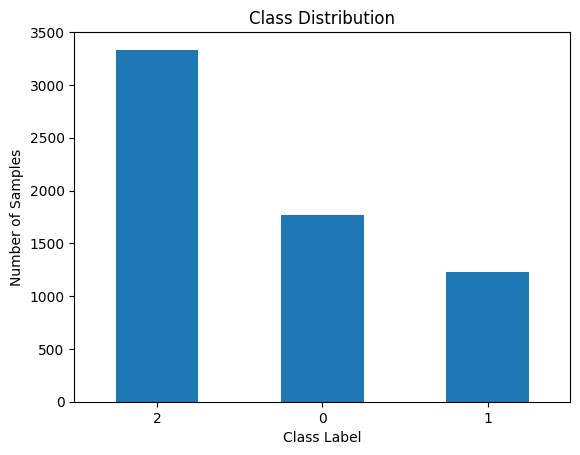

In [ ]:
# Count the occurrences of each class in the target column
class_counts = df["need_label"].value_counts()

# Print the count for each class
print(class_counts)

# plot the distribution to visualize the imbalance
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()


The label distribution in the dataset is as follows:

- Relatedness (2): 3,334 samples

- Autonomy (0): 1,771 samples

- Competence (1): 1,229 samples

This reveals a significant class imbalance, with Relatedness being overrepresented compared to Autonomy and especially Competence.

In [ ]:
# Creating a new dataframe merging the embeddings and needs labels
final_df = pd.concat([text_embeddings["Embeddings"], df["need_label"]], axis=1)

In [ ]:
final_df.head()

,Embeddings,need_label
0,"[-0.048260726, 0.00067045004, 0.04343376, 0.04...",0
1,"[-0.0032542767, -0.0050565773, -0.0061653233, ...",0
2,"[-0.013028014, 0.00015843856, -0.010279144, 0....",0
3,"[-0.041166335, -0.004530204, 0.014472111, 0.02...",0
4,"[-0.049580667, 0.029443955, 0.011005492, 0.031...",0


In [ ]:
# importing libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from keras import layers

#splitting the data
train_df, test_df = train_test_split(
    final_df, test_size=0.3, random_state = 1, stratify=final_df["need_label"] # using stratify to prevent biases due to class imbalance
)

In [ ]:
# Extract inputs (X) and outputs (y)
x_train = np.stack(train_df["Embeddings"])
y_train = train_df["need_label"]

x_val = np.stack(test_df["Embeddings"])
y_val = test_df["need_label"]


In [ ]:
# Define input and output sizes
embedding_size = x_train.shape[1]
num_classes = final_df["need_label"].nunique()

In [ ]:
# Build the classification model
def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
    return keras.Sequential(
        [
            layers.Input(shape=(input_size,), name="embedding_inputs"),
            layers.Dense(input_size, activation="relu", name="hidden"),
            layers.Dense(num_classes, activation="softmax", name="output_probs"),
        ]
    )

# Instantiate the model
classifier = build_classification_model(embedding_size, num_classes)
classifier.summary()

# Compile the model
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 768)               590592    
                                                                 
 output_probs (Dense)        (None, 3)                 2307      
                                                                 
Total params: 592,899
Trainable params: 592,899
Non-trainable params: 0
_________________________________________________________________


2025-04-16 10:54:28.652843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-16 10:54:28.703797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2025-04-16 10:54:28.703819: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-04-16 10:54:28.704737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep

In [ ]:
# Set training parameters
NUM_EPOCHS = 20
BATCH_SIZE = 32

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

# Train the model
history = classifier.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

Epoch 1/20
139/139 [==============================] - 1s 3ms/step - loss: 0.7564 - accuracy: 0.6808 - val_loss: 0.5941 - val_accuracy: 0.7528
Epoch 2/20
139/139 [==============================] - 0s 2ms/step - loss: 0.4963 - accuracy: 0.8028 - val_loss: 0.5212 - val_accuracy: 0.7943
Epoch 3/20
139/139 [==============================] - 0s 2ms/step - loss: 0.4480 - accuracy: 0.8222 - val_loss: 0.5038 - val_accuracy: 0.7969
Epoch 4/20
139/139 [==============================] - 0s 2ms/step - loss: 0.4166 - accuracy: 0.8344 - val_loss: 0.4957 - val_accuracy: 0.8090
Epoch 5/20
139/139 [==============================] - 0s 2ms/step - loss: 0.4038 - accuracy: 0.8385 - val_loss: 0.4912 - val_accuracy: 0.8033
Epoch 6/20
139/139 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8394 - val_loss: 0.6590 - val_accuracy: 0.7617
Epoch 7/20
139/139 [==============================] - 0s 2ms/step - loss: 0.3893 - accuracy: 0.8480 - val_loss: 0.5069 - val_accuracy: 0.8075
Epoch 

In [ ]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

60/60 [==============================] - 0s 951us/step - loss: 0.5328 - accuracy: 0.8096


{'loss': 0.5327904224395752, 'accuracy': 0.8095738887786865}

The accuracy is quite good at face value. However, due to the class imbalance, this number can be misleading. For example, if the model is just guessing “Relatedness” most of the time (the dominant class), it could still reach high accuracy without understanding the minority classes (Autonomy, Competence).

For a better evaluation use additional metrics like:

Precision, Recall, F1-score (especially macro F1),



In [ ]:
# Save the model
classifier.save("model.h5")


## Test the network with new tweets

Now that our model is nd is good enough to play with,, we can experiment by testing it on new, manually crafted tweets to evaluate how well it generalizes beyond the training data.


Below is another version of the function for the embedding, see
https://www.kaggle.com/code/lucabis/day-2-classification-embedding-keras

In [ ]:
#Another Function for embedding

from google.api_core import retry
import tqdm
from tqdm.rich import tqdm as tqdmr
import warnings

# Add tqdm to Pandas...
tqdmr.pandas()

# ...But suppress the experimental warning.
warnings.filterwarnings("ignore", category=tqdm.TqdmExperimentalWarning)

# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

@retry.Retry(predicate=is_retriable, timeout=300.0)
def embed_fn(text: str) -> list[float]:
    # You will be performing classification, so set task_type accordingly.
    response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=text,
        config=types.EmbedContentConfig(
            task_type="classification",
        ),
    )

    return response.embeddings[0].values


In [ ]:
def make_prediction(text: str) -> list[float]:
    """Infer categories from the provided text."""
    # Remember that the model takes embeddings as input, so calculate them first.
    embedded = embed_fn(text)

    # And recall that the input must be batched, so here they are wrapped as a
    # list to provide a batch of 1.
    inp = np.array([embedded])

    # And un-batched here.
    [result] = classifier.predict(inp)
    return result

In [ ]:
text = """
App locked me out of the car and its freezing #ThanksTech #firstworldproblems
"""

# Assuming 'embed_fn' is available from 'make_embed_text_fn'
embedded = embed_fn([text])  # This will give the embedding for your input text

# Predict
result = classifier.predict(np.array([embedded]))  # Classifier predicts probabilities for each class

# Iterate over the three classes: 0, 1, 2 (Autonomy, Competence, Relatedness)
for idx in range(3):  # Loop over the 3 classes
    # Print each class label and its predicted probability
    print(f"Class {idx} ({le.classes_[idx]}): {result[0][idx] * 100:.2f}%")


1/1 [==============================] - 0s 9ms/step

Class 0 (Autonomy): 63.89%

Class 1 (Competence): 14.36%

Class 2 (Relatedness): 21.74%

The model confidently classifies this tweet as expressing Autonomy (63.89%). This might be a signla of improved generalization: note that the tweet’s structure and theme closely mirror the earlier “laptop crash” example used for prompting (both highlight loss of control due to technology) indicating the model likely learned to associate such patterns with autonomy-related needs.